In [212]:
cd(@__DIR__)
include("table_reader.jl")

extract_series (generic function with 1 method)

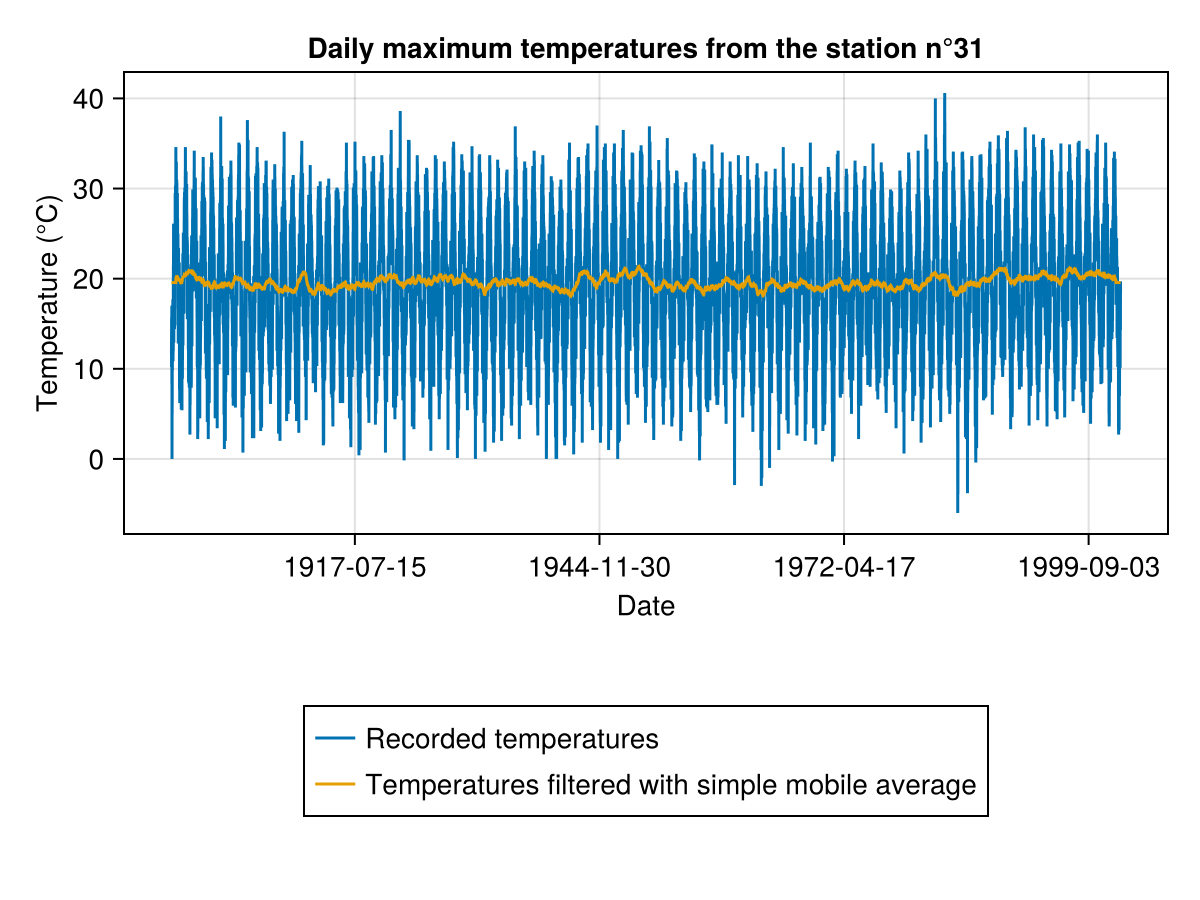

In [213]:
series,fig=extract_series("TX_STAID000031.txt",plot=true)
fig

## Drift

MSE estimators to estimate drift

In [214]:
N=size(series)[1]
X=cat(ones(N),1:N,dims=2)
beta=inv(transpose(X)*X)*transpose(X)*series[!,2]

2-element Vector{Float64}:
 19.366009056392556
  1.0215034069842917e-5

There is only a constant

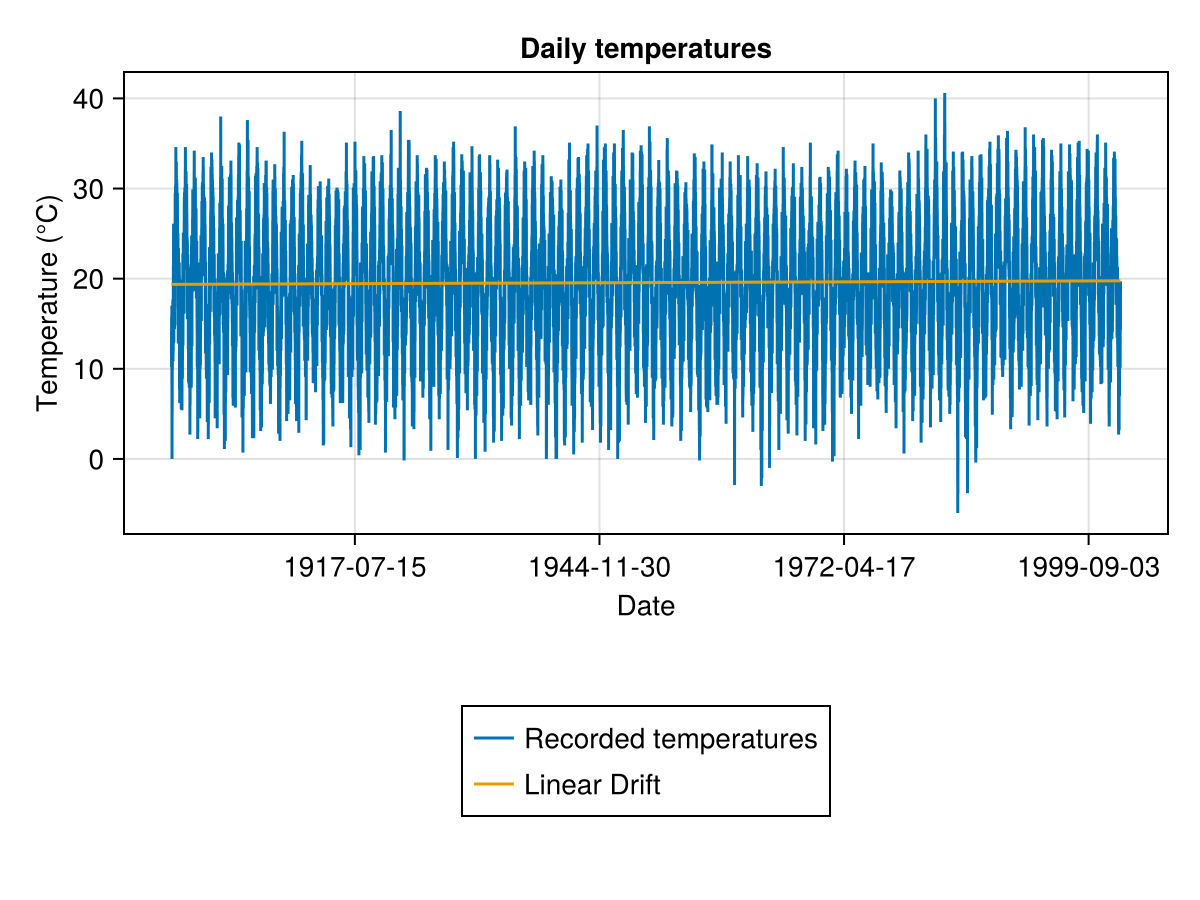

In [215]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE, series[!,2])
plot2=lines!(ax,series.DATE,X*beta)
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Linear Drift"])
current_figure()

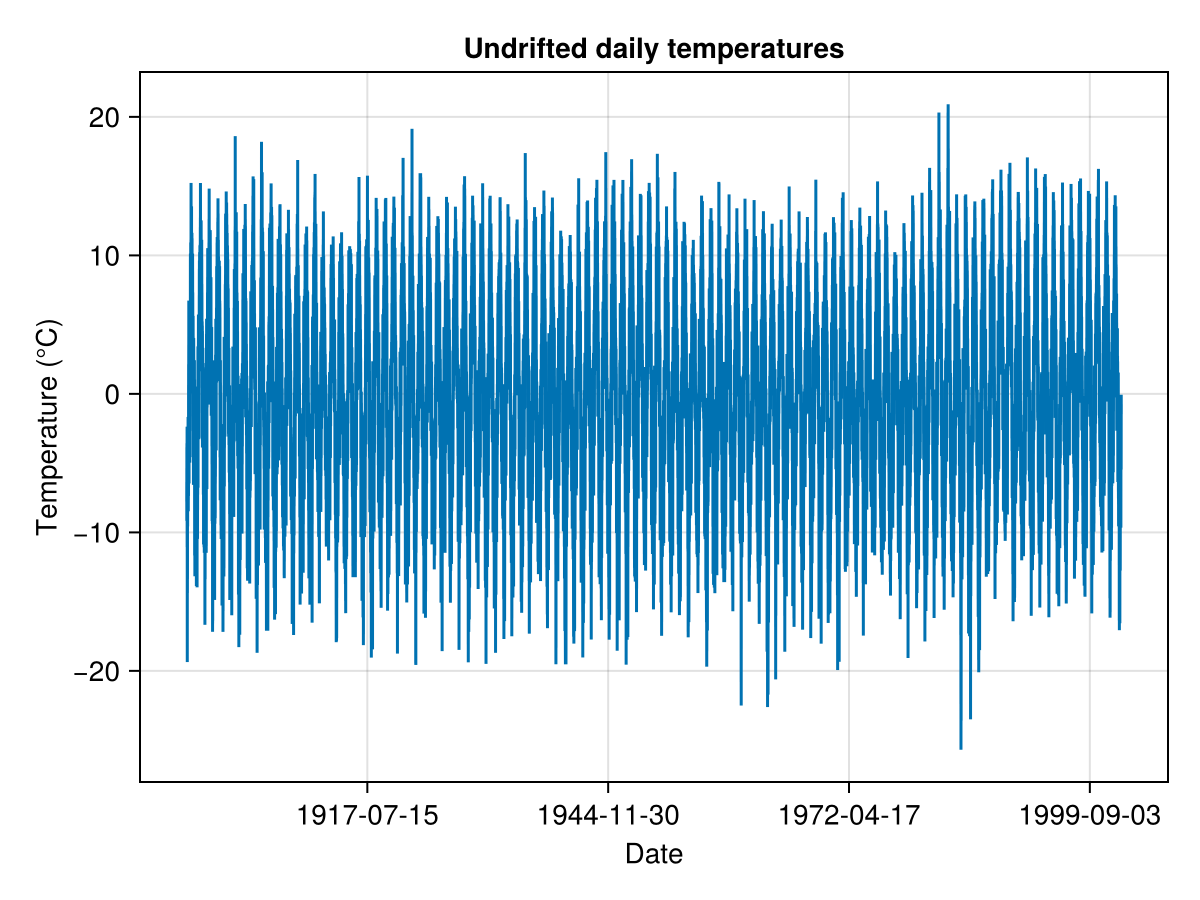

In [216]:
undrifted_series=series[!,2]-X*beta

fig, ax = lines(series.DATE, undrifted_series)
ax.title="Undrifted daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

## Periodicity

In [217]:
k=N ÷ 365
k*365
collect(1:365:k*365)

106-element Vector{Int64}:
     1
   366
   731
  1096
  1461
  1826
  2191
  2556
  2921
  3286
     ⋮
 35406
 35771
 36136
 36501
 36866
 37231
 37596
 37961
 38326

In [218]:
k=N ÷ 365 #k : number of years
average_period=mean(undrifted_series[i:364+i] for i in 1:365:(k-1)*365)

365-element Vector{Float64}:
 -7.840852999024626
 -7.86848226167774
 -7.472302000521335
 -7.786597929841122
 -7.358036716303765
 -7.416142169433068
 -7.493295241609997
 -7.134257837596449
 -7.360934719297186
 -7.45713541052173
  ⋮
 -8.060680027343965
 -7.8959283376161356
 -7.814986171697822
 -7.5330916248271285
 -7.524530411289771
 -8.095969197752408
 -7.9950270318341
 -7.9178943897253165
 -7.976952223807

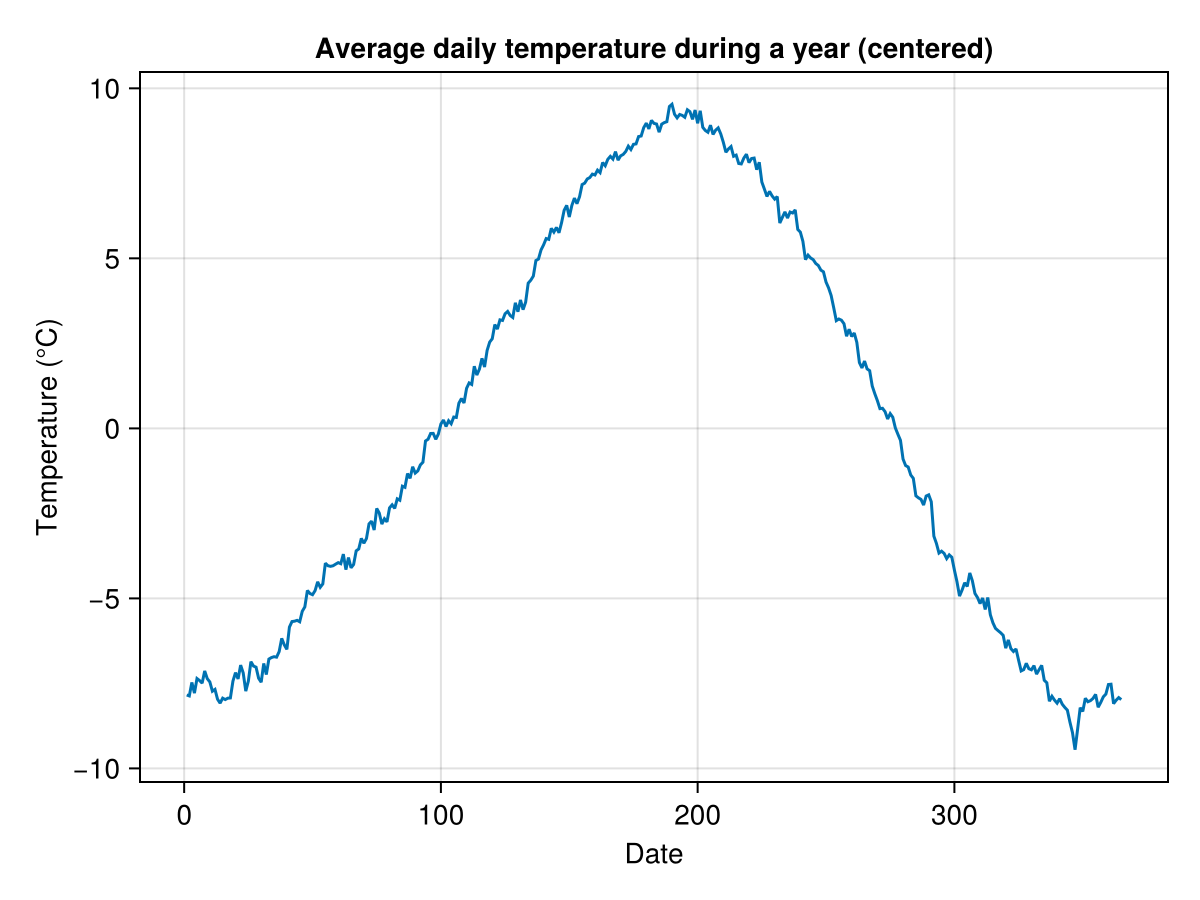

In [220]:
fig, ax = lines(1:365, average_period)
ax.title="Average daily temperature during a year (centered)"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

In [221]:
repeated_period=append!(repeat(average_period,outer=k),average_period[1:N % 365])
filtered_series=undrifted_series-repeated_period

38758-element Vector{Float64}:
  0.07483372759799867
  0.8024527752170441
  1.106262299026568
 -1.379451986687716
  1.9919765847408577
 -0.349928177163906
  3.6272146799789526
  2.8681670609313343
  2.6948337275980006
  3.8910242037884757
  ⋮
  2.687233107054826
  0.718661678483397
 -0.9632430834213661
 -1.3070526072308875
  0.3367569165786324
  3.538661678483394
  3.9415188213405354
  2.140566440388157
  2.7843759641976815

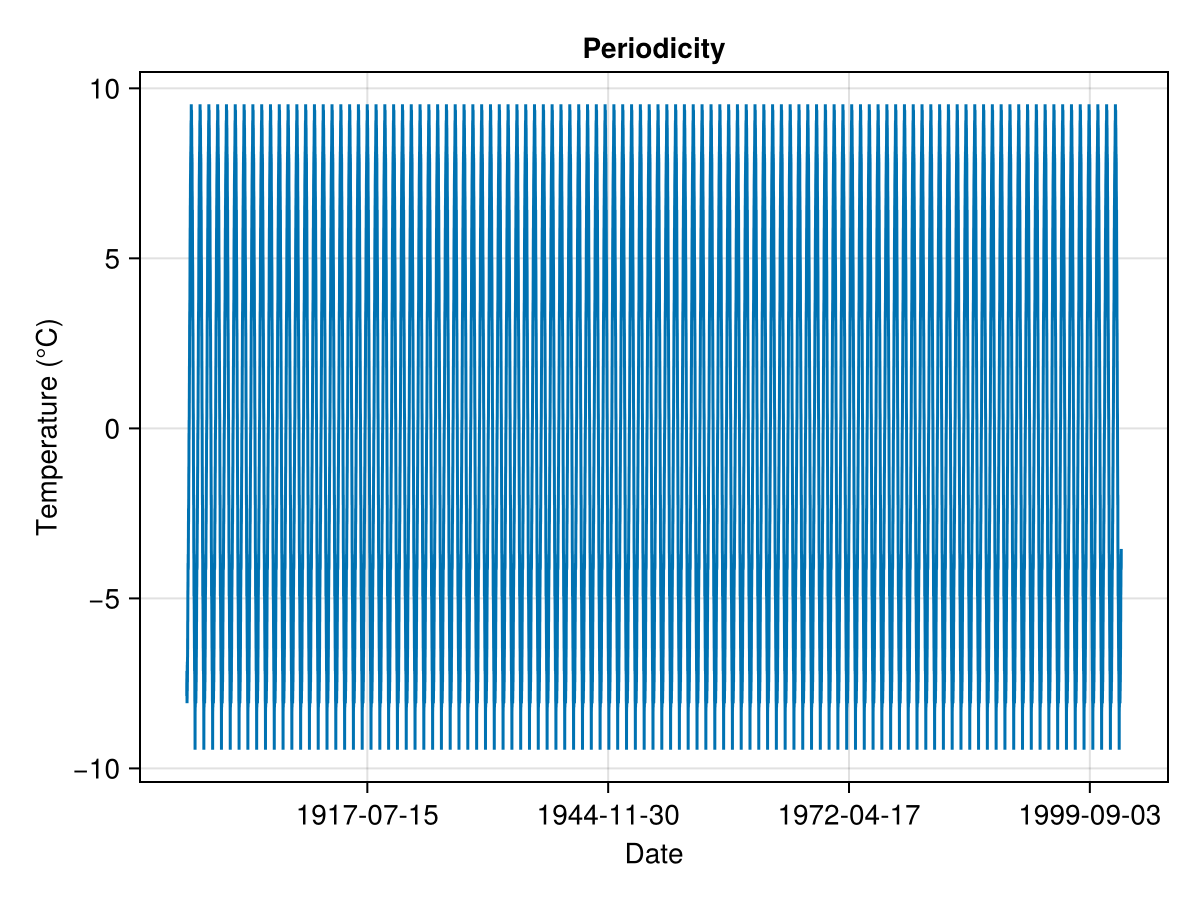

In [222]:
fig, ax = lines(series.DATE, repeated_period)
ax.title="Periodicity"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

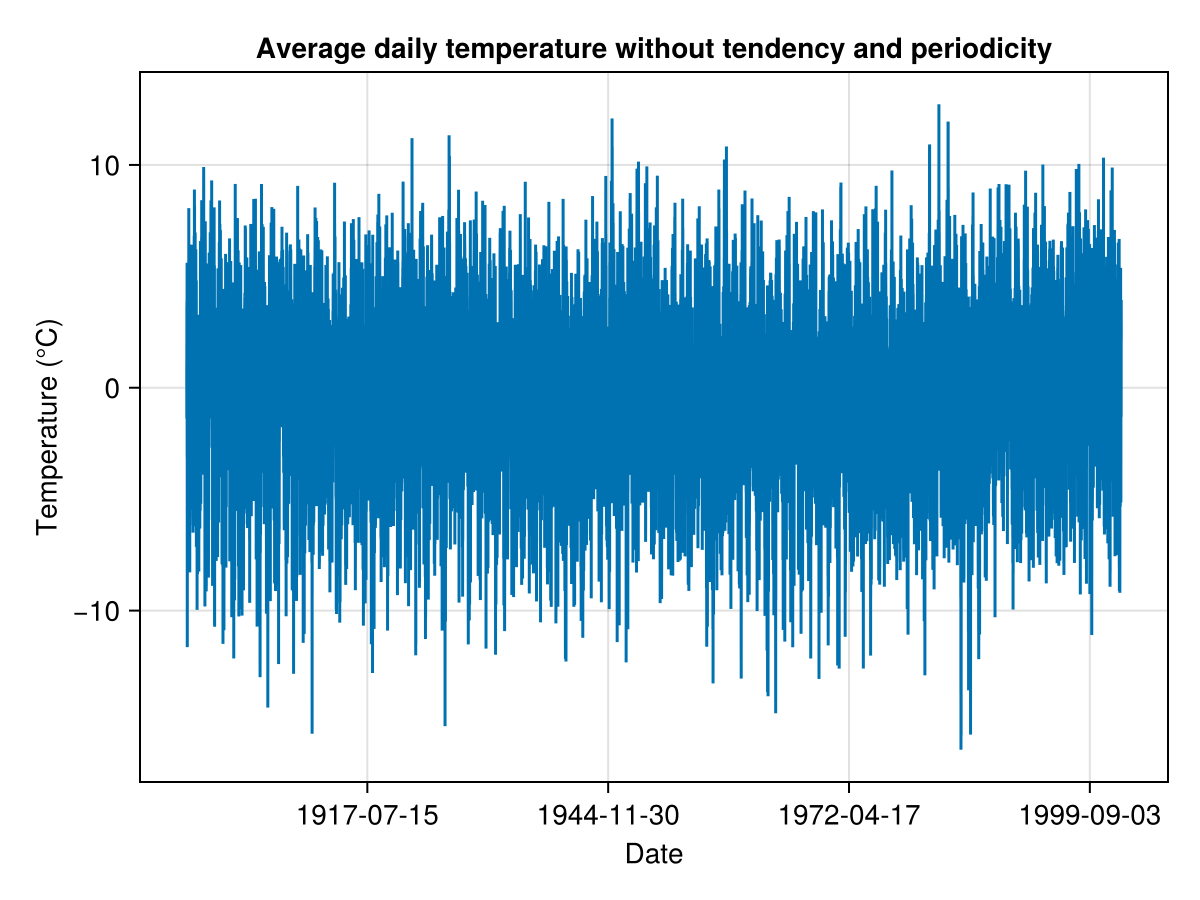

In [223]:
fig, ax = lines(series.DATE, filtered_series)
ax.title="Average daily temperature without tendency and periodicity"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

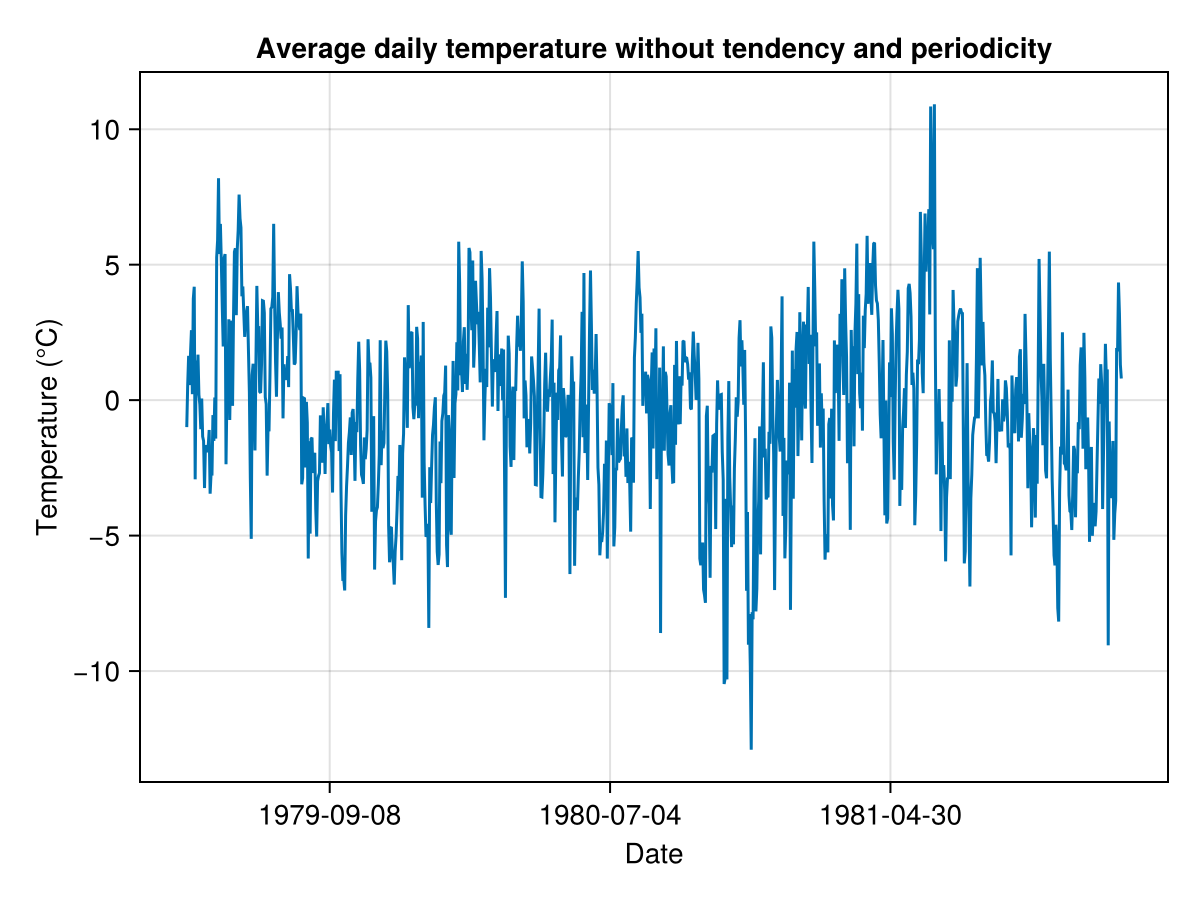

In [224]:
fig, ax = lines(series.DATE[30000:31000], filtered_series[30000:31000])
ax.title="Average daily temperature without tendency and periodicity"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

## Autocorrelations

In [225]:
using LinearAlgebra
γ(h::Int,x)=dot(x[1:end-h],x[1+h:end])/length(x) #x is supposed to be centered
γ(h::Vector{Int},x)=[dot(x[1:end-i],x[1+i:end]) for i in h]/length(x)
γ(h::UnitRange{Int},x)=[dot(x[1:end-i],x[1+i:end]) for i in h]/length(x)
ρ(h,x)=γ(h,x)/γ(0,x)

ρ (generic function with 1 method)

### ACF

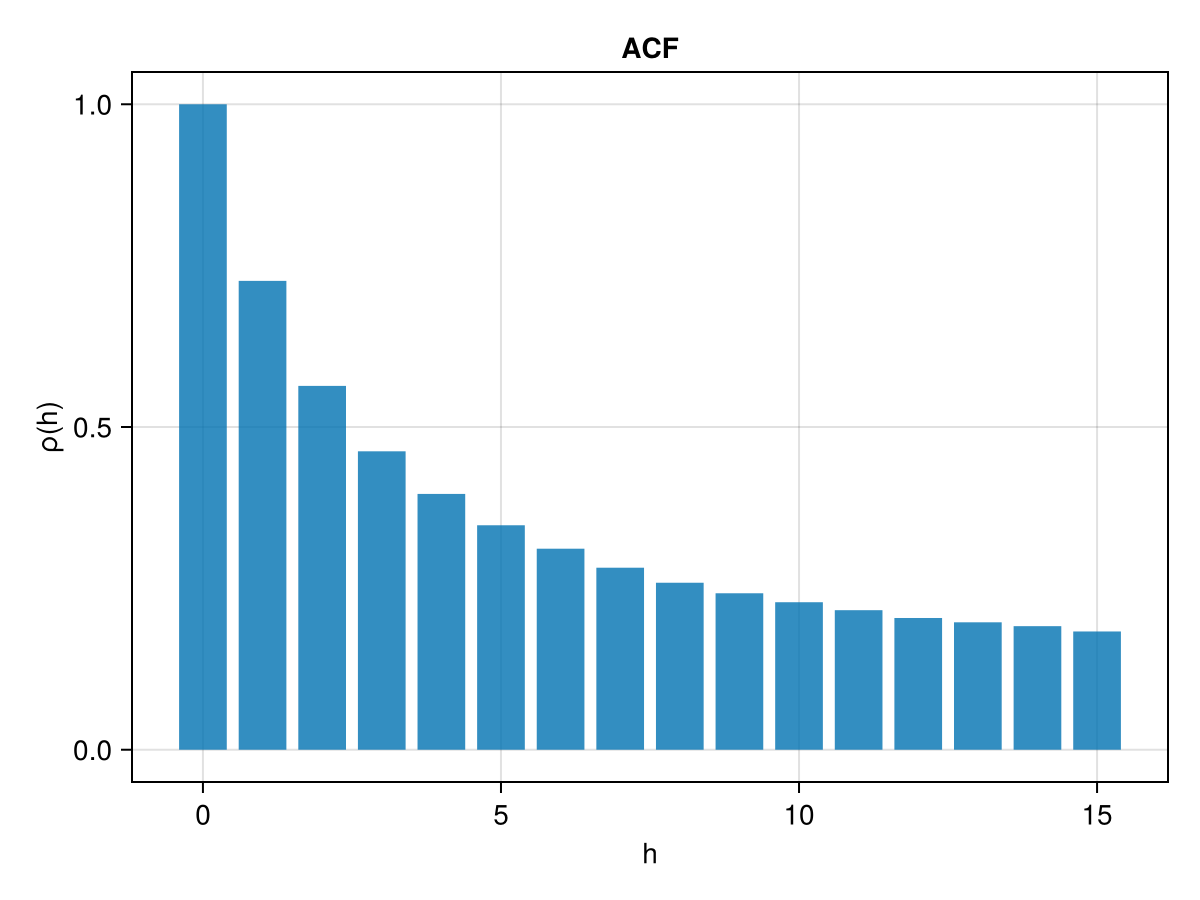

In [226]:
fig, ax = barplot(0:15, ρ(0:15,filtered_series))
ax.title="ACF"
ax.xlabel="h"
ax.ylabel="ρ(h)"
current_figure()

With the package StatsBase

In [227]:
using StatsBase

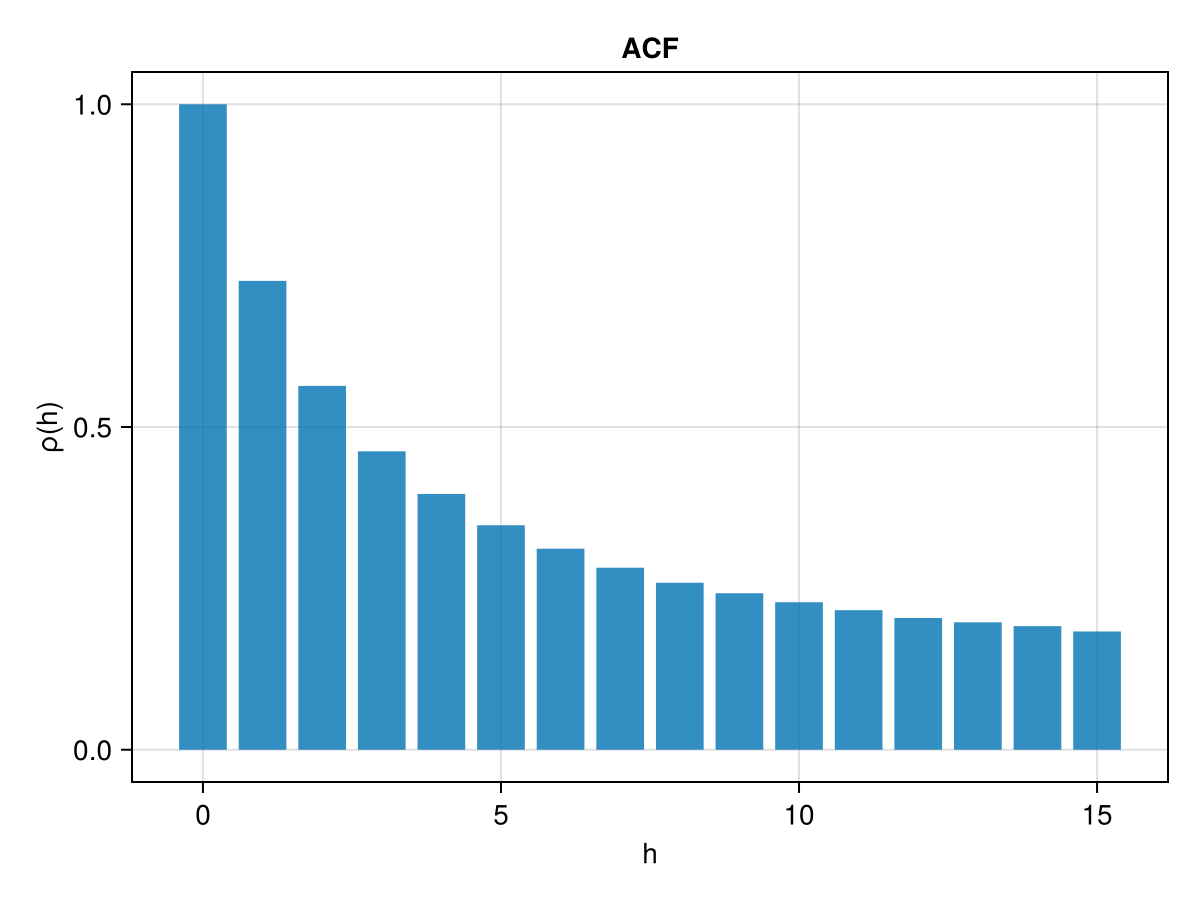

In [228]:
fig, ax = barplot(0:15, autocor(filtered_series,0:15))
ax.title="ACF"
ax.xlabel="h"
ax.ylabel="ρ(h)"
current_figure()

### PACF

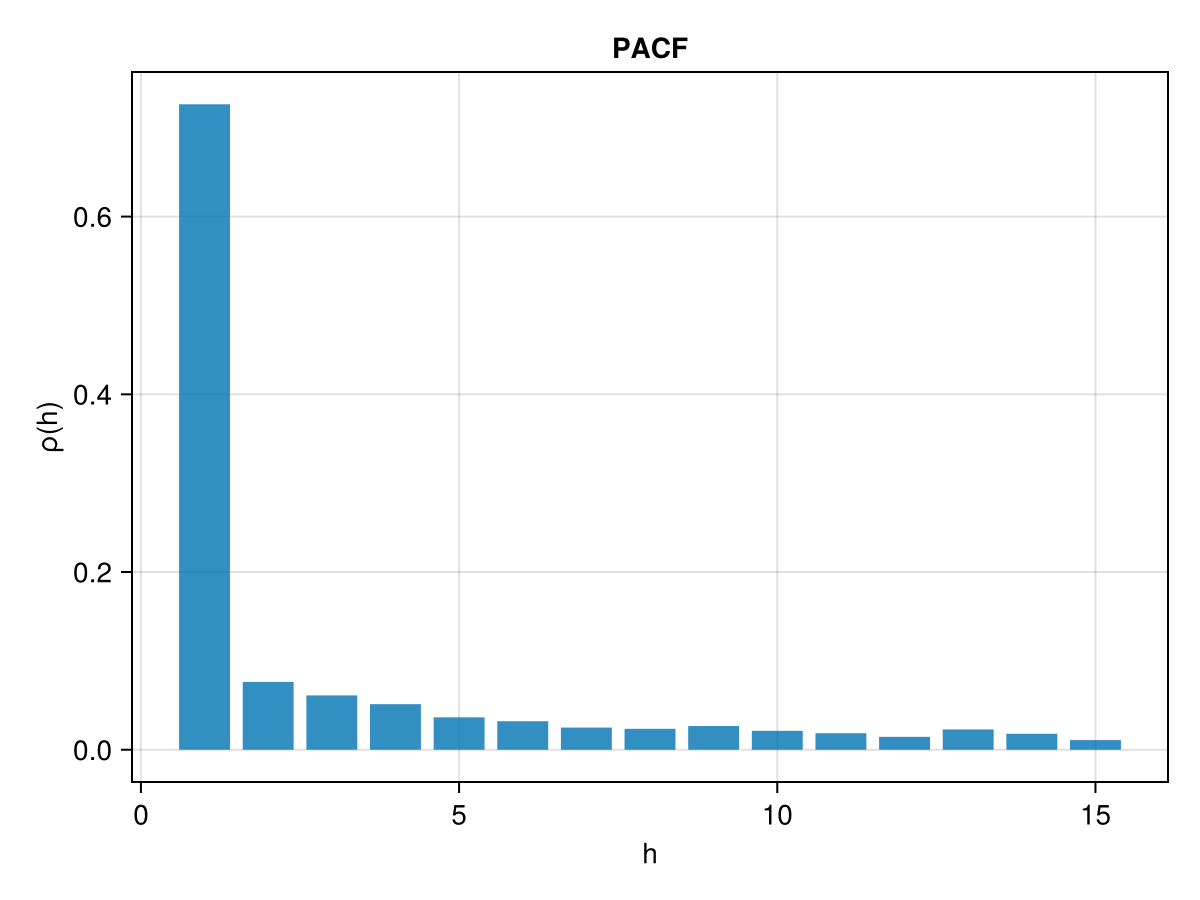

In [229]:
fig, ax = barplot(1:15, pacf(filtered_series,1:15))
ax.title="PACF"
ax.xlabel="h"
ax.ylabel="ρ(h)"
current_figure()

It looks like an AR(1) model

## Estimation with Likelyhood

In [230]:
try
    using Distributions, Optim
catch ;
    import Pkg
    Pkg.add("Distributions")
    Pkg.add("Optim")
    using Distributions, Optim
end

In [231]:
function Log_Likelyhood_AR(x,Estimators,p)
    #!!Estimators[end]=σ^2, not σ
    EV_vec=[dot(Estimators[1:end-1],x[(t-1):-1:(t-p)]) for t in (p+1):length(x)]
    return (-(length(x)-p)*(log(2π)+log(Estimators[end])) - sum((x[p+1:end] - EV_vec) .^2 )/Estimators[end] )/2
end

Log_Likelyhood_AR (generic function with 1 method)

In [232]:
x=filtered_series
Φ=0.8
σ=10^2

100

In [233]:
function LL_AR_Estimation(x,p)
    Estimators= [zeros(p) ; 1]
    f(Estimators_) = - Log_Likelyhood_AR(x,Estimators_,p)
    Estimators=Optim.minimizer(optimize(f,Estimators))
    return Estimators[1:end-1] , Estimators[end]
end

LL_AR_Estimation (generic function with 1 method)

In [234]:
opt=LL_AR_Estimation(x,1)
Φ, σ=opt[1][1] ,opt[2]^0.5


(0.7264050577291687, 2.201220351689081)

## Prediction "on the past" 

In [235]:
pred=x[1:end-1]*Φ#+σ*randn(length(x)-1)

38757-element Vector{Float64}:
  0.05435959821591311
  0.5829057545064685
  0.8035945291879971
 -1.0020409000245067
  1.4469818660338352
 -0.25418959773380995
  2.6348270890061993
  2.083451059472726
  1.9575408494663367
  2.8264596613785606
  ⋮
  1.1847976164317535
  1.9520197202618943
  0.5220394780464733
 -0.6997046476199199
 -0.9494496246106133
  0.24462192742799832
  2.5705017408427273
  2.8631392069564767
  1.5549182887032802

In [236]:
try
    using LaTeXStrings
catch ; 
    import Pkg
    Pkg.add("LaTeXStrings")
    using LaTeXStrings
end

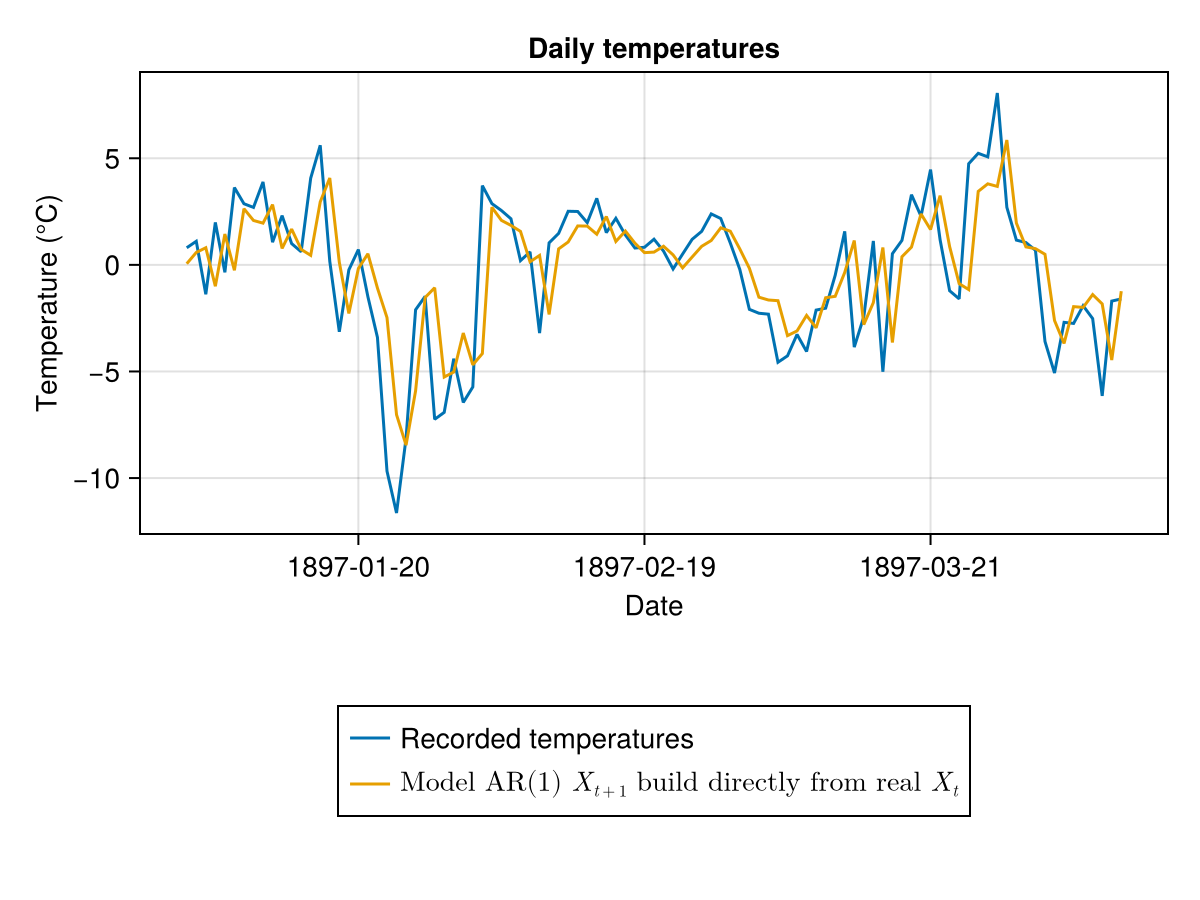

In [237]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE[2:100], x[2:100])
plot2=lines!(ax,series.DATE[2:100],pred[1:99])
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures",L"Model AR(1) $X_{t+1}$ build directly from real $X_t$"])
current_figure()

In [238]:
# using CSV
# Df=DataFrame(x=x)
# CSV.write("series.csv",Df)

## Forecasting

In [239]:
function forecast(x::Number,Φ,n)
    #Forecast the model for n days
    prev = [x * Φ]
    if n > 1 
        for _ in 2:n
            append!(prev, prev[end] * Φ)
        end
    end
    return prev
end

forecast (generic function with 1 method)

In [240]:
prev=forecast(x[end],Φ[1],365*2)

730-element Vector{Float64}:
 2.022584783012727
 1.469215816066498
 1.0672457996863922
 0.7752527467324066
 0.5631475162448505
 0.4090732040478786
 0.2971528444018553
 0.2158533290921164
 0.15679694998019209
 0.11389809750211902
 ⋮
 1.643858182430433e-100
 1.194106897906945e-100
 8.67405290108893e-101
 6.300875898361368e-101
 4.5769881206935175e-101
 3.324747320038094e-101
 2.4151132689471708e-101
 1.754350493552051e-101
 1.2743690715458732e-101

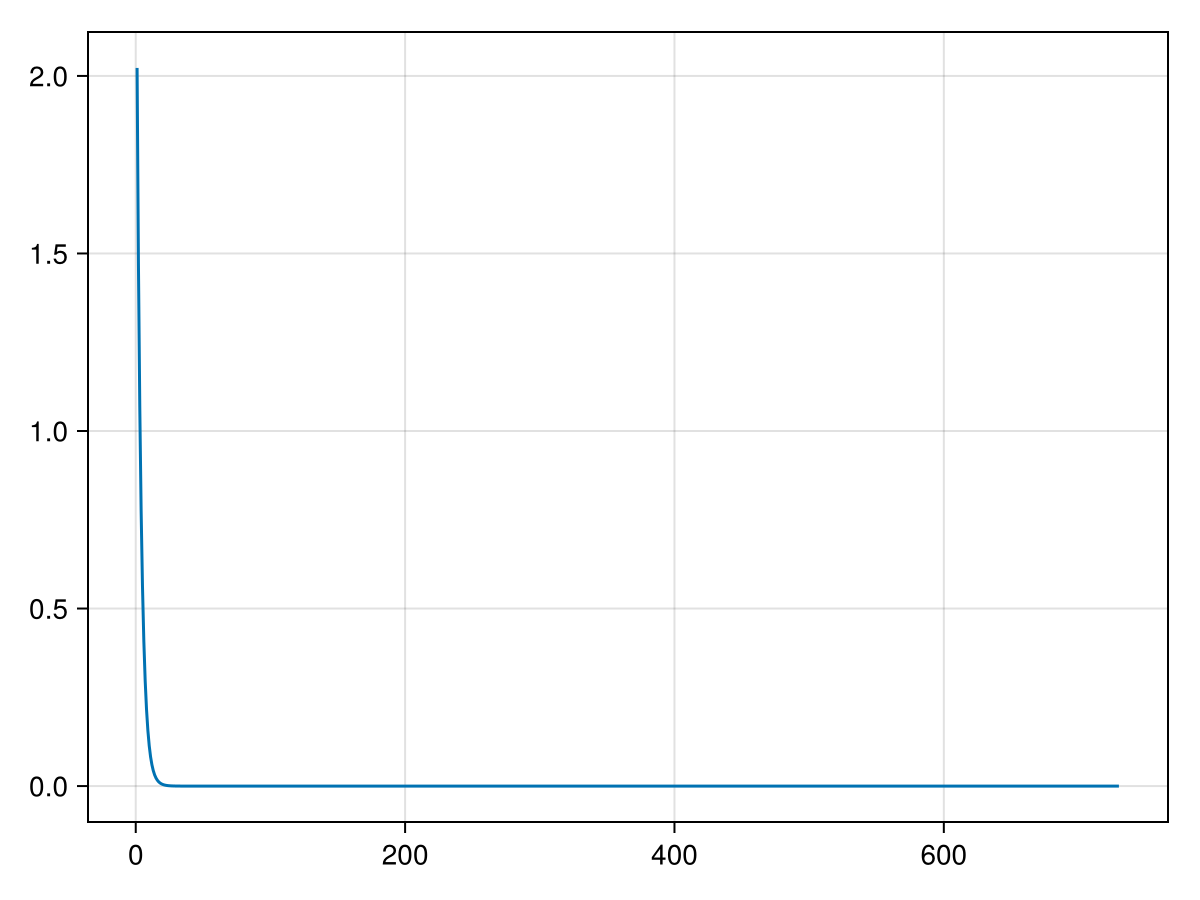

In [241]:
fig,ax,plot1=lines(1:(365*2),prev)

In [242]:
new_date_range=series.DATE[end]:Day(1):(series.DATE[end]+Day(365*2))

Date("2003-03-31"):Day(1):Date("2005-03-30")

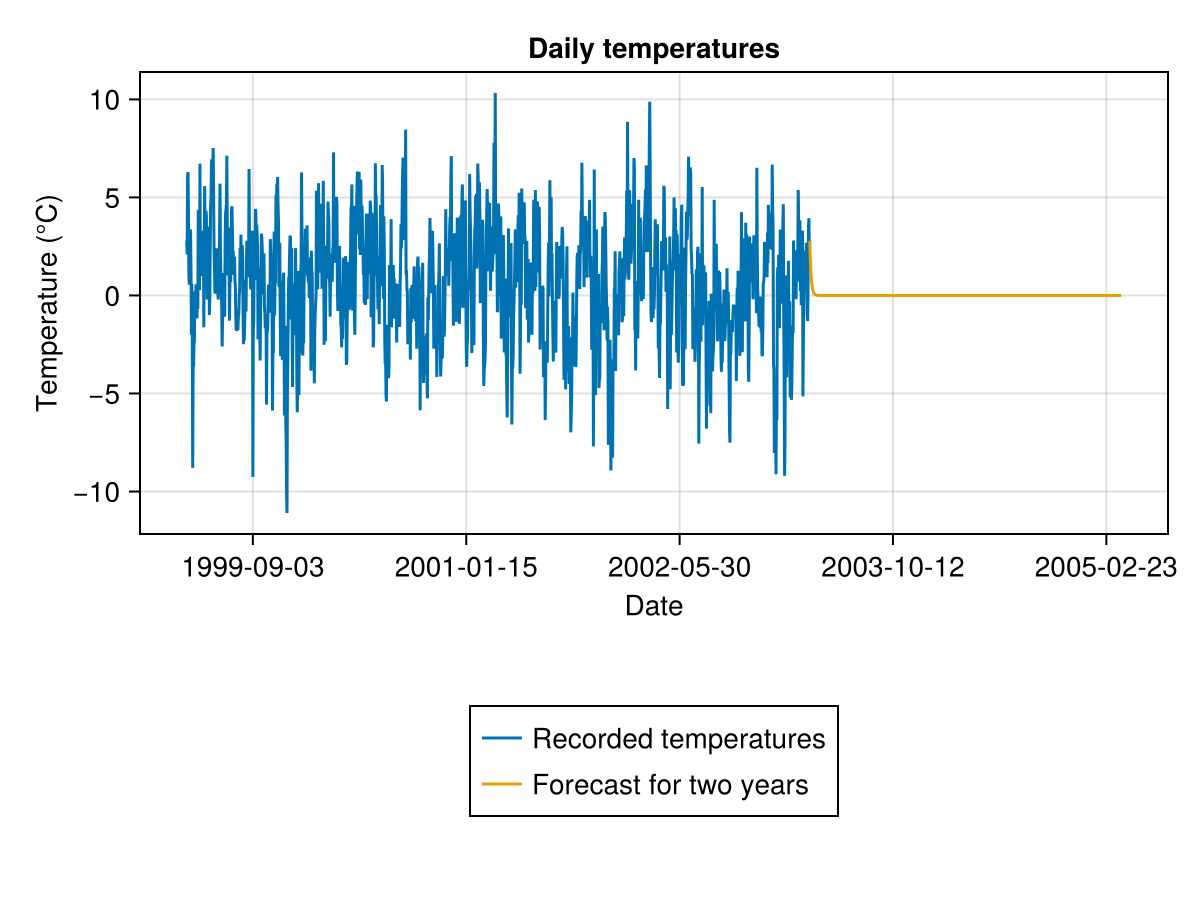

In [243]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE[end-365*4:end], x[end-365*4:end])
plot2=lines!(ax,new_date_range,[x[end] ;prev])
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Forecast for two years"])
current_figure()

It is not very realistic.

## Simulation

In [ ]:
function simulation(x::Vector,Φ::Vector,σ,n)
    y,p=copy(x),length(x)
    return simulation!(x,Φ,σ,n,y,p)
end

function simulation!(x::Vector,Φ::Vector,σ,n,y,p)
    for _ in 1:n
        append!(y, dot(y[end:-1:end-p+1],Φ) + σ * randn())
    end
    return y[p+1:end]
end

simulation(x::Number,Φ::Number,σ,n) = simulation([x],[Φ],σ,n)

simulation (generic function with 3 methods)

In [245]:
Φ

0.7264050577291687

In [246]:
noised_prev=simulation(x[end],Φ,σ,365*2)

730-element Vector{Float64}:
  4.311349712794626
  4.1745992444057505
  4.160753909317561
 -0.009825242371923615
  3.9050965783729934
  3.8437017908368425
  3.7466253695414125
  5.496742812250505
  5.959420778302942
  5.78140027491294
  ⋮
  2.2954035051506168
  0.8936732498910567
  4.6634890119779975
  0.5609147566584003
  0.7120453274327141
  0.9915879023411276
  4.280424642013775
  2.499955042045454
  4.478946057818579

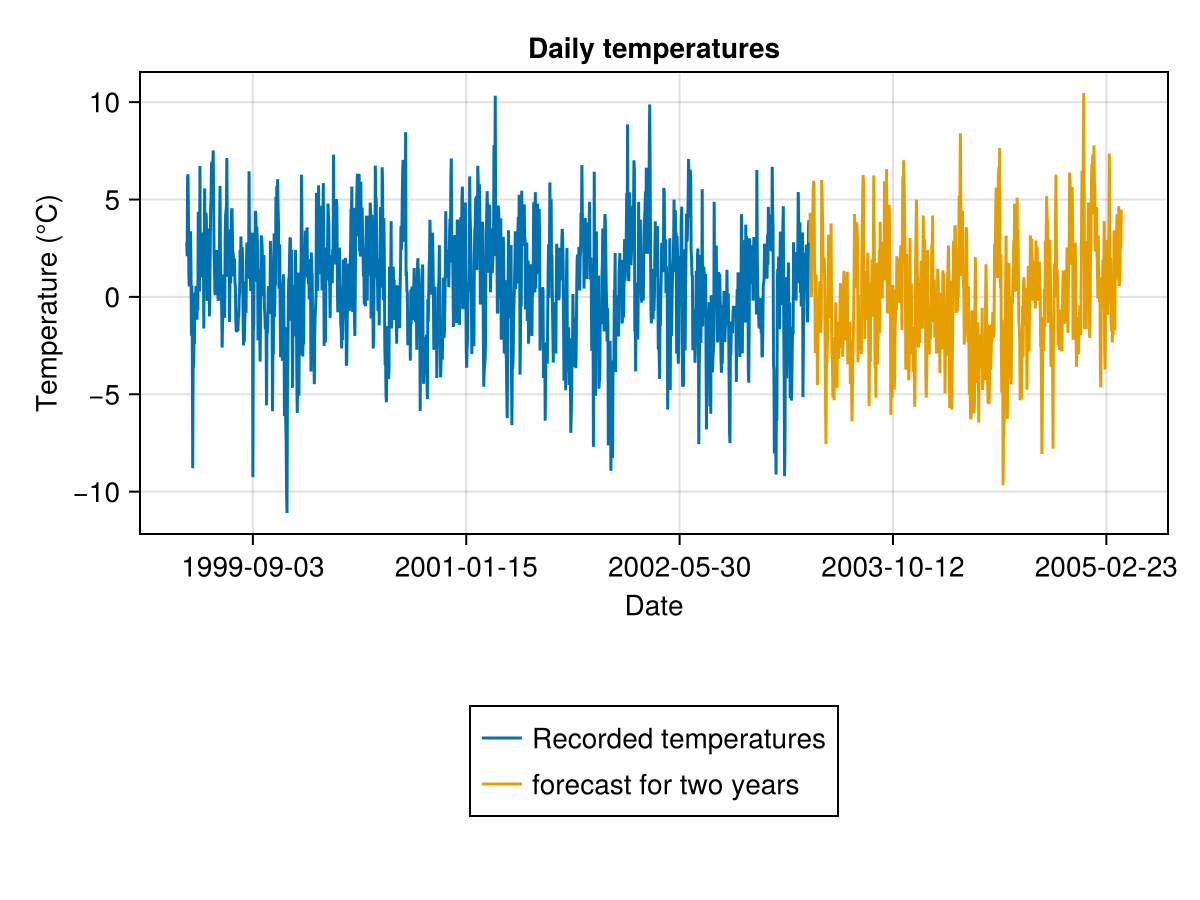

In [247]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE[end-365*4:end], x[end-365*4:end])
plot2=lines!(ax,new_date_range,[x[end] ;noised_prev])
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","forecast for two years"])
current_figure()

In [248]:
noised_prev_pm=noised_prev + repeat(repeated_period[end-364:end],2) .+ beta[1]

730-element Vector{Float64}:
 20.44152543356009
 20.162859988232384
 20.287099676205365
 16.546986499958
 20.54189810566885
 20.220493103098626
 20.757692181054843
 22.370656551587007
 22.51046715974823
 22.488626917514637
  ⋮
 17.712337827889378
 16.279168786167176
 20.33087909512481
 15.772104148580667
 16.27941498051139
 16.25704257848097
 19.643011960262406
 18.263484526212395
 20.298655803141926

In [249]:
function plot_simulation(n_future_period=2,n_old_period::Int=0) #Use global variables
    new_date_range=series.DATE[end]:Day(1):(series.DATE[end]+Day(365*n_future_period))
    noised_prev=simulation(x[end],Φ[1],σ,365*n_future_period)
    noised_prev_pm=noised_prev + repeat(repeated_period[end-364:end],n_future_period) .+ beta[1]
    fig=Figure()
    if n_old_period==0
        ax, plot1=lines(fig[1:2, 1:2], series.DATE, series.TX)
    else
        ax, plot1=lines(fig[1:2, 1:2], series.DATE[end-365*n_old_period:end], series.TX[end-365*n_old_period:end])
    end
    plot2=lines!(ax,new_date_range,[series.TX[end] ;noised_prev_pm])
    ax.title="Daily temperatures"
    ax.xlabel="Date"
    ax.ylabel="Temperature (°C)"
    Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Simulation for $(n_future_period) years"])
    return fig
end

plot_simulation (generic function with 3 methods)

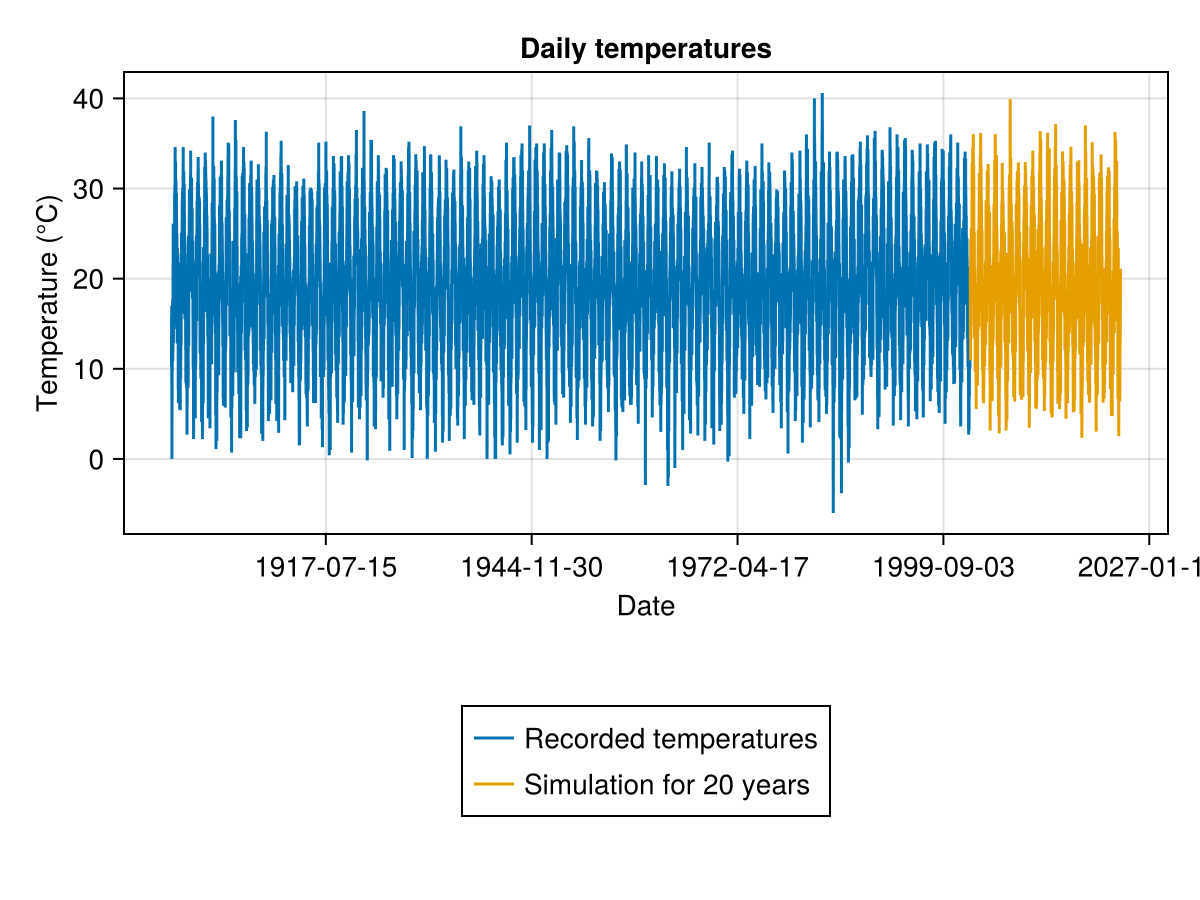

In [250]:
plot_simulation(20)

## Sampling simulations

In [251]:
series.DATE[1]

1897-01-01

In [ ]:
function sample_simulation(x,Φ,σ,size_multiplicator=1)
    #Return a sample of annual simulation of weather, according to the AR(1) model.
    Output=[]
    for _ in 1:size_multiplicator
        simulated=simulation(x,Φ,σ,365k -1)
        append!(Output,[simulated[(365i):365*(i+1)-1] for i in 1:(k-1)]) #We do not put the first period
    end
    return Output
end

sample_simulation (generic function with 2 methods)

In [272]:
sample_simulation(x[1],Φ,σ)

105-element Vector{Any}:
 [-0.12436652937433701, -0.31784598233697825, 0.6494715339110915, -1.7478476551301418, -0.4597655024034083, 1.0097182593494642, 0.7545620233372183, 0.535755915699024, -0.1313774587794821, 1.1356311647833108  …  1.3820932710419664, -0.2727109832176393, 0.09844312624739199, 3.339688519961335, 1.7981814941606968, 0.4071333357935023, -0.549321094055985, 2.129084527308018, -0.2087483525282181, -0.053012152892158576]
 [-1.4750287042527535, 1.0231021095367667, 5.613721693129447, 1.9622930564797683, -2.8912917243109657, 0.0814527582313107, 2.78417348887759, -0.2544154423633209, -0.755846711076904, -4.897556193865142  …  -1.287150941632509, -2.63299993170437, -2.732257434683679, -3.510296001103103, -2.754017925780522, -2.202222862366114, -3.337546983885324, -2.769112534749637, -0.48726649707553094, -5.695608037889949]
 [-4.441584962447149, -0.470949299426358, 1.6955586199917458, -0.09001749538543868, 1.7265382923983044, 0.08489940647911376, 0.9527790506005136, -0.778414